In [1]:
%load_ext autoreload
%autoreload 2
from astropy.table import Table
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import sys
from tqdm.auto import tqdm, trange
sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/')
import model_halo_abundance as cl_count
import model_halo_abundance as cl_count
sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/sbi/')
import simulation as simulation
sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/pinocchio/')
import pinocchio_binning_scheme as binning_scheme
import pyccl as ccl
from multiprocessing import Pool
from matplotlib.cm import get_cmap
import pickle

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Initialize SBI object

In [2]:
stacked_simulator_pl = simulation.Universe_simulation( 'stacked_counts' ,
                                                        variable_params=['omega_m', 
                                                                         'sigma_8', 
                                                                         'h',
                                                                         'alpha' , 
                                                                         'c' , 
                                                                         'beta',
                                                                         'sigma' ],
                                                        fixed_params={'w_0': -1, 'w_a': 0 } )
stacked_simulator_pl.selection_richness = 0
def dOmega_z(z): return 0.25 * 4 * np.pi
stacked_simulator_pl.dOmega = dOmega_z
stacked_simulator_pl.richness_bins = None
stacked_simulator_pl.redshift_bins = None
stacked_simulator_pl.sigma_mwl = 0
stacked_simulator_pl.include_mwl_measurement_errors = False
stacked_simulator_pl.correlation_mass_evolution = False
stacked_simulator_pl.set_richness_mass_relation( 'constantins model' )
stacked_simulator_pl.set_bins( z_bins = np.arange( 0.2 , 1 , 0.001 ) , 
                               log10m_bins=  np.arange( 14.3 , 15.5 , 0.001))
stacked_simulator_pl.massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
stacked_simulator_pl.halobias_fct = ccl.halos.hbias.tinker10.HaloBiasTinker10(mass_def=stacked_simulator_pl.massdef)
stacked_simulator_pl.hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=stacked_simulator_pl.massdef)
stacked_simulator_pl.add_SSC = True
stacked_simulator_pl.use_hybrid = True
stacked_simulator_pl.Z_edges_hybrid = binning_scheme.redshift_edges
Z_bin_hybrid = [[stacked_simulator_pl.Z_edges_hybrid[i], stacked_simulator_pl.Z_edges_hybrid[i+1]] for i in range(len(stacked_simulator_pl.Z_edges_hybrid)-1)]


In [3]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

def compute_Sij_matrix(cosmo, Z_bin_hybrid, f_sky = 1):
    import cluster_abundance_covariance as cl_covar
    CLCovar = cl_covar.Covariance_matrix()
    Sij_partialsky_exact_standard = CLCovar.compute_theoretical_Sij(Z_bin_hybrid, cosmo, 
                                                                f_sky,
                                                                S_ij_type='full_sky_rescaled_approx', 
                                                                path=None)
    return Sij_partialsky_exact_standard

def compute_sigmaij_matrix(cosmo, z_grid, f_sky = 1):
    import cluster_abundance_covariance as cl_covar
    z_grid_center = np.array([(z_grid[i] + z_grid[i+1])/2 for i in range(len(z_grid)-1)])
    CLCovar = cl_covar.Covariance_matrix()
    sigmaij_partialsky_exact_standard = CLCovar.compute_theoretical_sigmaij(z_grid_center, cosmo, f_sky)
    return sigmaij_partialsky_exact_standard

# Compute (or load) fiducial Sij matrix

In [4]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

In [5]:
have_PySSC = False
f_sky = 0.25
if have_PySSC:
    z_grid = np.linspace(0.2, 1, 1000)
    stacked_simulator_pl.sigmaij_SSC = compute_sigmaij_matrix(cosmo, z_grid)/f_sky
    save_pickle(stacked_simulator_pl.sigmaij_SSC*f_sky, f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/sigma_ij_full_sky.pkl', )
    
    stacked_simulator_pl.Sij_SSC = compute_Sij_matrix(cosmo, Z_bin_hybrid)/f_sky
    save_pickle(stacked_simulator_pl.Sij_SSC*f_sky, f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/S_ij_full_sky.pkl', )
else: 
    S_ij_full_sky = load(f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/S_ij_full_sky.pkl' )
    stacked_simulator_pl.Sij_SSC = S_ij_full_sky/f_sky
    
    sigma_ij_full_sky = load(f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/sigma_ij_full_sky.pkl' )
    stacked_simulator_pl.sigmaij_SSC = sigma_ij_full_sky/f_sky


# Hybrid

In [6]:
stacked_simulator_pl.use_hybrid = True
%time Nth_hybrid, log10m_hybrid, z_hybrid = stacked_simulator_pl.get_halo_catalogue(cosmo, return_Nth = True)

CPU times: user 3.7 s, sys: 18.4 ms, total: 3.72 s
Wall time: 1.15 s


In [7]:
Ncount_obs_hybrid, a, b = np.histogram2d(z_hybrid, log10m_hybrid, bins = [binning_scheme.redshift_edges, binning_scheme.logm_edges])

# Unbinned

In [8]:
stacked_simulator_pl.use_hybrid = False
%time Nth_unbinned, log10m_unbinned, z_unbinned = stacked_simulator_pl.get_halo_catalogue(cosmo,return_Nth = True)

CPU times: user 6.67 s, sys: 3.17 s, total: 9.84 s
Wall time: 2.4 s


In [9]:
Ncount_obs_unbinned, a, b = np.histogram2d(z_unbinned, log10m_unbinned, bins = [binning_scheme.redshift_edges, binning_scheme.logm_edges])

In [10]:
Z_bin = binning_scheme.Z_bin
LogMass_bin = binning_scheme.LogMass_bin
Richness_bin = binning_scheme.Richness_bin

# Compare to standard approach

In [11]:
logm_edges = binning_scheme.logm_edges
redshift_edges = binning_scheme.redshift_edges
richness_edges = binning_scheme.richness_edges
Z_bin = binning_scheme.Z_bin
LogMass_bin = binning_scheme.LogMass_bin
Richness_bin = binning_scheme.Richness_bin

In [12]:
clc = cl_count.ClusterAbundance()
z_grid = np.linspace(0.2, 1., 1000)
logm_grid = np.linspace(14.3, 15.5, 1001)
clc.set_cosmology(cosmo = cosmo, hmd = stacked_simulator_pl.hmd)
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
clc.sky_area = f_sky * 4 * np.pi
Ncount_th = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = LogMass_bin, method = 'simps')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


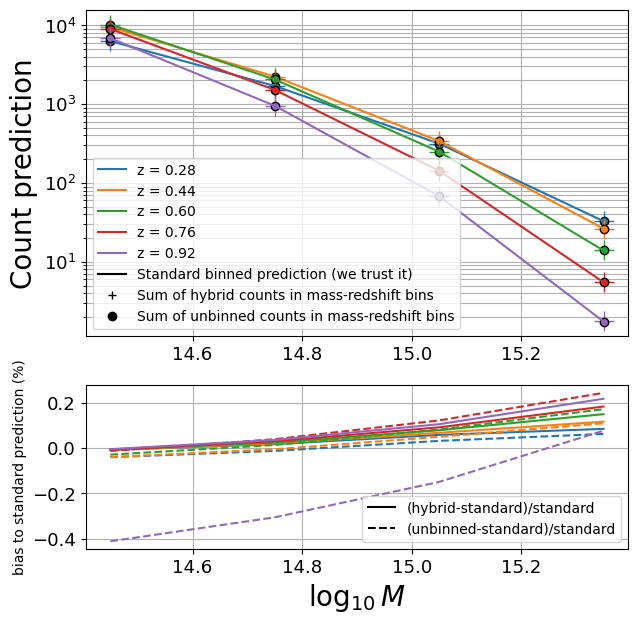

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(7,7), gridspec_kw={'height_ratios': [2,1]})
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.3, hspace=None)

for j in range(2):
    ax[j].grid(which='both')
    ax[0].legend()
    ax[j].tick_params(axis='both', which = 'major', labelsize= 13)
for i, z_bin in enumerate(Z_bin):
    Count_hybrid = []
    Count_unbinned = []
    for logmass_bin in LogMass_bin:
        mask_hybrid_m = (Nth_hybrid['logm_grid_center'] > logmass_bin[0])*(Nth_hybrid['logm_grid_center'] < logmass_bin[1])
        Count_hybrid.append(np.sum(Nth_hybrid['N_th'][i,:][mask_hybrid_m]))

        mask_unbinned_m = (Nth_unbinned['logm_grid_center'] > logmass_bin[0])*(Nth_unbinned['logm_grid_center'] < logmass_bin[1])
        mask_unbinned_z = (Nth_unbinned['z_grid_center'] > z_bin[0])*(Nth_unbinned['z_grid_center'] < z_bin[1])
        Count_unbinned.append(np.sum(Nth_unbinned['N_th'][:,mask_unbinned_z][mask_unbinned_m]))

        
    ax[0].plot(np.mean(LogMass_bin, axis=1), Count_hybrid, 'C'+str(i), ls = ' ', marker = '+', markersize=15)
    ax[0].plot(np.mean(LogMass_bin, axis=1), Count_unbinned, 'C'+str(i), ls = ' ', marker = 'o', markeredgecolor='k',)
    ax[0].plot(np.mean(LogMass_bin, axis=1), Ncount_th[i,:], 'C'+str(i), ls = '-',  label = 'z = '+f'{np.mean(Z_bin[i]):.2f}')
    ax[1].plot(np.mean(LogMass_bin, axis=1), 100*(np.array(Count_hybrid) - Ncount_th[i,:])/Ncount_th[i,:],'C'+str(i), )
    ax[1].plot(np.mean(LogMass_bin, axis=1), 100*(np.array(Count_unbinned) - Ncount_th[i,:])/Ncount_th[i,:],'--C'+str(i) )
ax[0].plot([], [], '-k', label = 'Standard binned prediction (we trust it)')
ax[0].plot([], [], '+k', label = 'Sum of hybrid counts in mass-redshift bins')
ax[0].plot([], [], 'ok', label = 'Sum of unbinned counts in mass-redshift bins')
ax[0].set_yscale('log')

ax[1].plot([], [], '-k', label = '(hybrid-standard)/standard')
ax[1].plot([], [], '--k', label = '(unbinned-standard)/standard')
ax[0].set_ylabel(r'Count prediction', fontsize=20,)
ax[0].legend()
ax[1].set_xlabel(r'$\log_{10}M$', fontsize=20,)
ax[1].set_ylabel(r'bias to standard prediction (%)', fontsize=10,)
ax[1].legend()

Text(0.5, 0, '$\\log_{10}M$')

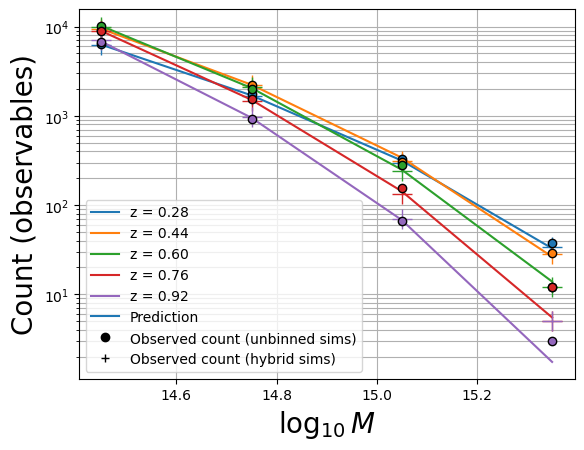

In [14]:
for i, z_bin in enumerate(Z_bin):
    Count_hybrid = []
    plt.plot(np.mean(LogMass_bin, axis=1), Ncount_obs_unbinned[i,:], 
             'C'+str(i), ls = ' ', marker = 'o', markeredgecolor='k', zorder=1000)
    plt.plot(np.mean(LogMass_bin, axis=1), Ncount_obs_hybrid[i,:],
             'C'+str(i), ls = ' ',  marker = '+', markersize=15)

    plt.plot(np.mean(LogMass_bin, axis=1), Ncount_th[i,:],
             'C'+str(i), ls = '-',  marker = '', label = 'z = '+f'{np.mean(Z_bin[i]):.2f}')

plt.plot([], [], '-', label = 'Prediction')
plt.plot([], [], 'ok', label = 'Observed count (unbinned sims)')
plt.plot([], [], '+k', label = 'Observed count (hybrid sims)')
plt.yscale('log')
plt.grid(which='both')
plt.ylabel(r'Count (observables)', fontsize=20,)
plt.legend()
plt.xlabel(r'$\log_{10}M$', fontsize=20,)